# Data Inspection notebook for HECKTOR dataset

In [1]:
import os, glob

import numpy as np
import matplotlib.pyplot as plt

import SimpleITK as sitk

## Read images

In [2]:
def read_nifti(file_path, print_info=True):
    sitk_image = sitk.ReadImage(file_path)
    if print_info:
        print("Loaded image:", file_path.split('/')[-1])
        print("Patient ID:", file_path.split('/')[-1].split('_')[0])
        
        if '_gtvt' in file_path: 
            modality = 'Binary GTV mask'
            sitk_image = sitk.Cast(sitk_image, sitk.sitkUInt8)
        elif '_ct' in file_path: modality = 'CT'
        elif '_pt' in file_path: modality = 'PT' 
        print("Modality:", modality)
        
        image_size = sitk_image.GetSize()
        pixel_spacing = sitk_image.GetSpacing()
        print("Image size:", image_size)
        print("Pixel spacing (mm):", pixel_spacing)
        print("Physical size (mm):", [image_size[i]*pixel_spacing[i] for i in range(3)])
        
        print("Components per pixel:", sitk_image.GetNumberOfComponentsPerPixel())
        
        print("\n")
        
    return sitk_image

In [3]:
# Original image
image_path = "../data/hecktor_train/hecktor_nii/CHGJ007/CHGJ007_ct.nii.gz"
print("Loading original CT ...")
sitk_image1 = read_nifti(image_path)


# Original GTV mask
gtv_mask_path = "../data/hecktor_train/hecktor_nii/CHGJ007/CHGJ007_ct_gtvt.nii.gz"
print("Loading original GTV mask ...")
sitk_image1_seg = read_nifti(gtv_mask_path)


# Resampled image
res_image_path = "../data/hecktor_train/resampled/CHGJ007_ct.nii.gz"
print("Loading resampled CT ...")
sitk_image2 = read_nifti(res_image_path)

Loading original CT ...
Loaded image: CHGJ007_ct.nii.gz
Patient ID: CHGJ007
Modality: CT
Image size: (512, 512, 91)
Pixel spacing (mm): (0.9765620231628418, 0.9765620231628418, 3.269989013671875)
Physical size (mm): [499.999755859375, 499.999755859375, 297.5690002441406]
Components per pixel: 1


Loading original GTV mask ...
Loaded image: CHGJ007_ct_gtvt.nii.gz
Patient ID: CHGJ007
Modality: Binary GTV mask
Image size: (512, 512, 91)
Pixel spacing (mm): (0.9765620231628418, 0.9765620231628418, 3.269989013671875)
Physical size (mm): [499.999755859375, 499.999755859375, 297.5690002441406]
Components per pixel: 1


Loading resampled CT ...
Loaded image: CHGJ007_ct.nii.gz
Patient ID: CHGJ007
Modality: CT
Image size: (141, 141, 48)
Pixel spacing (mm): (1.0, 1.0, 3.0)
Physical size (mm): [141.0, 141.0, 144.0]
Components per pixel: 1




## Visualization

In [4]:
def display_slices(sitk_image, 
                   sagittal_slice_idxs=[], coronal_slice_idxs=[], axial_slice_idxs=[], 
                   window_level = None, window_width = None,
                   title=None, dpi=80):

    spacing = sitk_image.GetSpacing()
    

    if window_level != None and window_width != None:
        # Apply window and change scan image scale to 0-255
        print("windowing")
        window_min = window_level - window_width//2
        window_max = window_level + window_width//2
        sitk_image = sitk.Cast(sitk.IntensityWindowing(sitk_image, windowMinimum=window_min, windowMaximum=window_max, 
                                                       outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)
           
    ndarray = sitk.GetArrayFromImage(sitk_image)
    
    
    # Figure settings
    fig, [ax1,ax2,ax3] = plt.subplots(3)
    #fig.set_size_inches(0.5*18.5, 0.8*10.5)
    figsize = (2000/dpi, 1000/dpi)
    fig.set_size_inches(*figsize)
    fig.set_dpi(dpi)
    #fig.subplots_adjust(hspace=0.05, top=0.95, bottom=0.05, left=0.25, right=0.75)
    
    
    # Extract axial slices --
    axial_slices = []
    for idx in axial_slice_idxs:
        if ndarray.ndim == 3 : image2d = ndarray[idx, :, :]
        if ndarray.ndim == 4 : image2d = ndarray[idx, :, :, :]
        axial_slices.append(image2d)
    
    axial_slices = np.hstack(axial_slices)  

    n_rows = image2d.shape[0] # #rows of the 2d array - corresponds to sitk image height
    n_cols = image2d.shape[1] # #columns of the 2d array - corresponds to sitk image width
    extent = (0, len(axial_slice_idxs)*n_cols*spacing[0], n_rows*spacing[1], 0)
    ax1.imshow(axial_slices, extent=extent, interpolation=None, cmap='gray')
    ax1.set_title(f"Axial slices: {axial_slice_idxs}")
    ax1.axis('off')
    
    
    # Extract coronal slices --
    coronal_slices = []
    for idx in coronal_slice_idxs:
        if ndarray.ndim == 3 : image2d = ndarray[:, idx, :]
        if ndarray.ndim == 4 : image2d = ndarray[:, idx, :, :]
        image2d = np.rot90(image2d, 2)
        coronal_slices.append(image2d)
        
    coronal_slices = np.hstack(coronal_slices)
    
    n_rows = image2d.shape[0] # #rows of the 2d array - corresponds to sitk image depth
    n_cols = image2d.shape[1] # #columns of the 2d array - corresponds to sitk image width
    extent = (0, len(coronal_slice_idxs)*n_cols*spacing[0], n_rows*spacing[2], 0)
    ax2.imshow(coronal_slices, extent=extent, interpolation=None, cmap='gray')
    ax2.set_title(f"Coronal slices: {coronal_slice_idxs}")
    ax2.axis('off')

    
    # Extract sagittal slices --
    sagittal_slices = []
    for idx in sagittal_slice_idxs:
        if ndarray.ndim == 3 : image2d = ndarray[:, :, idx]
        if ndarray.ndim == 4 : image2d = ndarray[:, :, idx, :]
        image2d = np.rot90(image2d, k=2)
        image2d = np.flip(image2d, axis=1)
        sagittal_slices.append(image2d)
        
    sagittal_slices = np.hstack(sagittal_slices)
        
    n_rows = image2d.shape[0] # #rows of the 2d array - corresponds to sitk image depth
    n_cols = image2d.shape[1] # #columns of the 2d array - corresponds to sitk image height
    extent = (0, len(sagittal_slice_idxs)*n_cols*spacing[1], n_rows*spacing[2], 0)
    ax3.imshow(sagittal_slices, extent=extent, interpolation=None, cmap='gray')
    ax3.set_title(f"Sagittal slices: {sagittal_slice_idxs}")
    ax3.axis('off')
    
    if title:
        fig.suptitle(title, fontsize='x-large')
    plt.show()

    
    
    
def display_overlay_slices(sitk_image, sitk_image_seg,
                           sagittal_slice_idxs=[], coronal_slice_idxs=[], axial_slice_idxs=[], 
                           window_level = None, window_width = None, opacity=0.5,
                           title=None, dpi=80):

    # Apply window and change scan image scale to 0-255
    window_min = window_level - window_width//2
    window_max = window_level + window_width//2
    sitk_image_win = sitk.Cast(sitk.IntensityWindowing(sitk_image, windowMinimum=window_min, windowMaximum=window_max, 
                                                       outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)

    # Overlay seg mask over the scan
    overlay_image = sitk.LabelOverlay(sitk_image_win, sitk_image_seg, opacity)

    # Display
    display_slices(overlay_image,
                           sagittal_slice_idxs, coronal_slice_idxs, axial_slice_idxs, 
                           window_level=None, window_width=None,
                           dpi=dpi, title=title)
        

### Display original CT

windowing


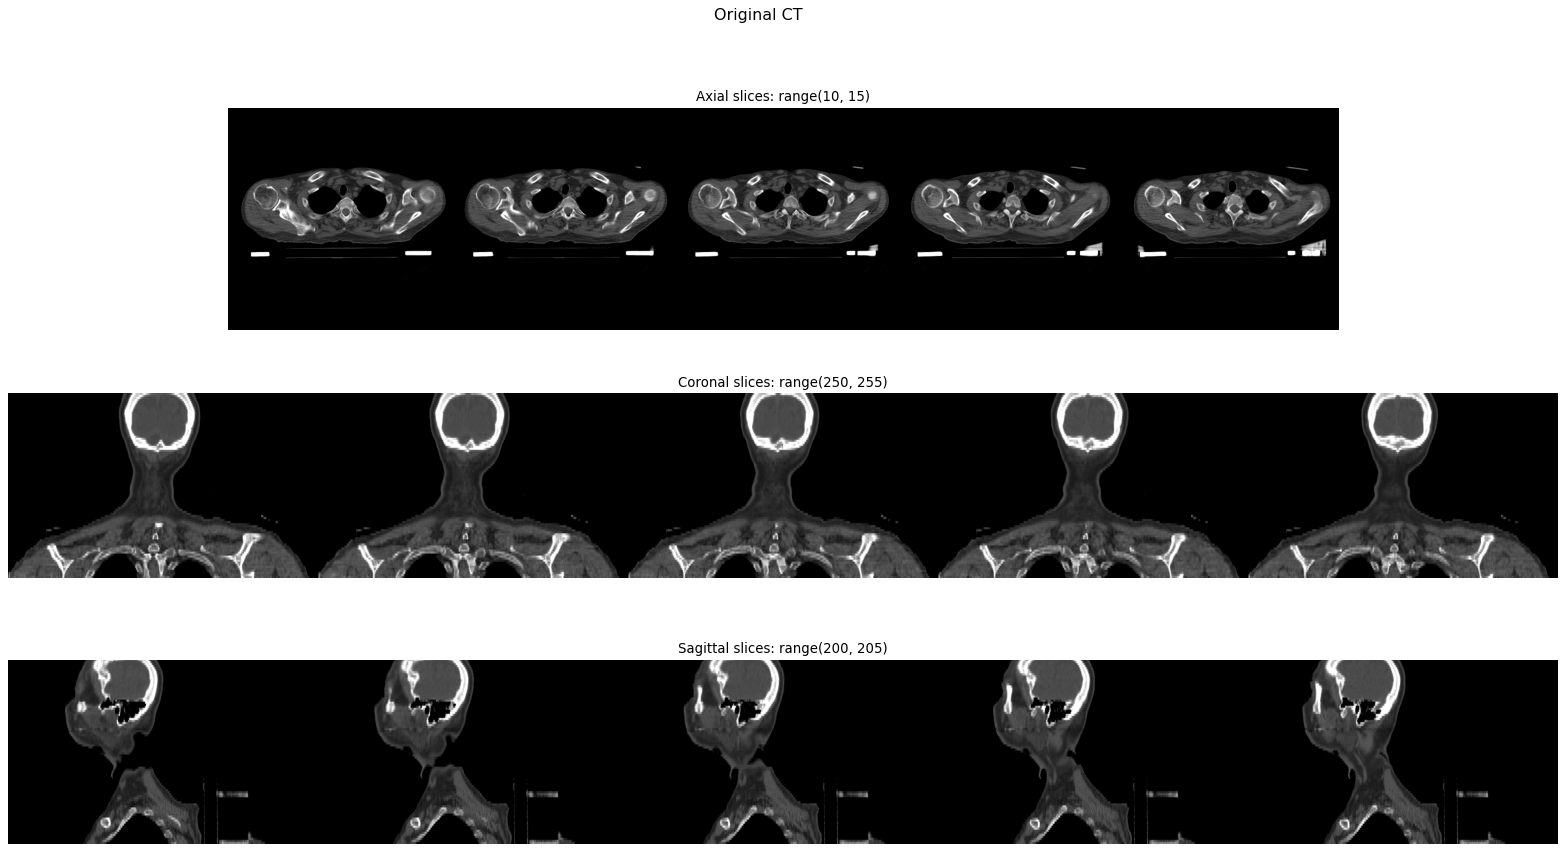

In [5]:
display_slices(sitk_image1, 
             sagittal_slice_idxs=range(200,205),
             coronal_slice_idxs=range(250,255),
             axial_slice_idxs=range(10,15),
             window_level = 200, window_width = 800,
             title="Original CT")

### Display resampled CT

windowing


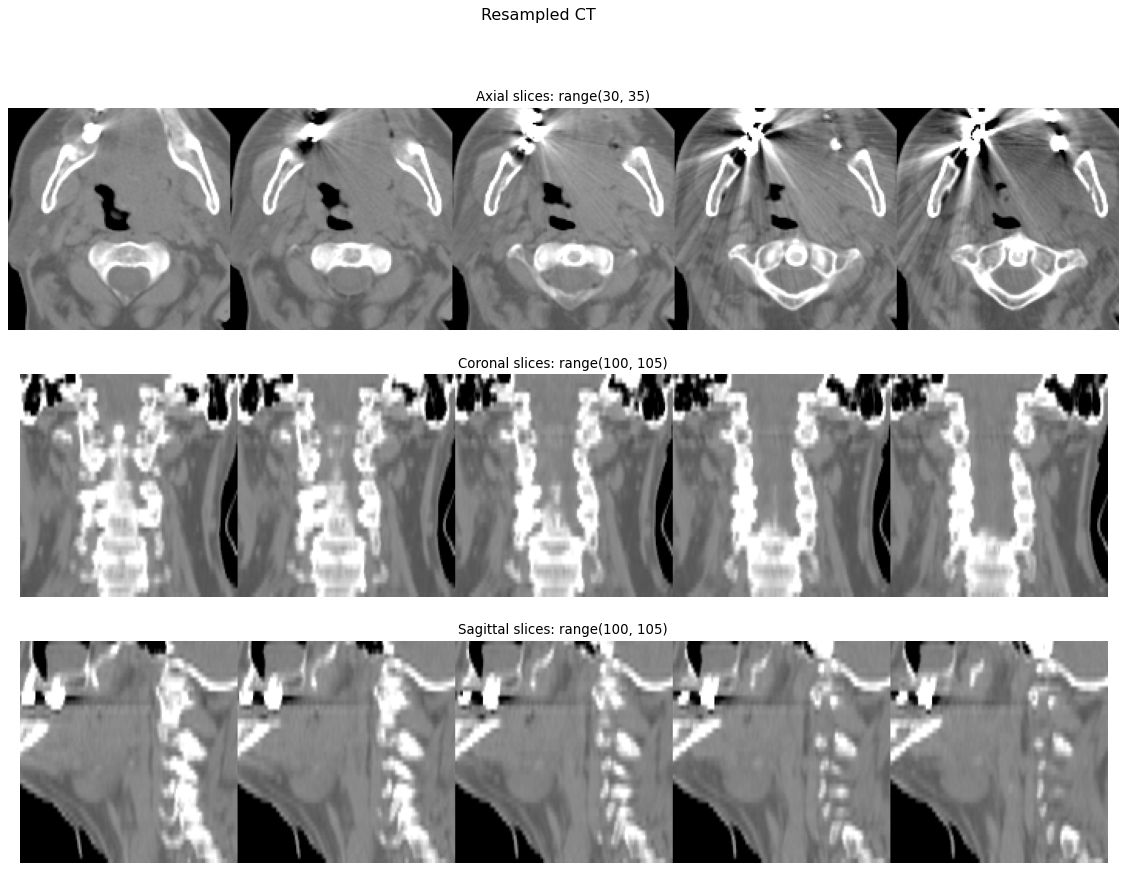

In [6]:
display_slices(sitk_image2, 
             sagittal_slice_idxs=range(100,105),
             coronal_slice_idxs=range(100,105),
             axial_slice_idxs=range(30,35),
             window_level = 20, window_width = 800,
             title="Resampled CT")

### Display original GTV segmentation mask

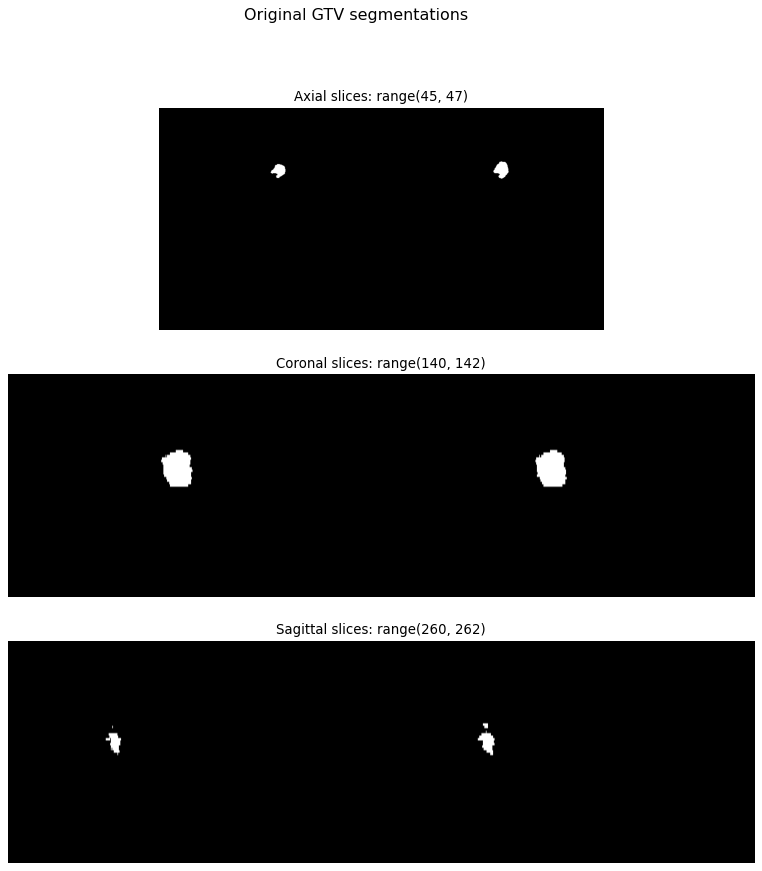

In [7]:
display_slices(sitk_image1_seg, 
             sagittal_slice_idxs=range(260,262),
             coronal_slice_idxs=range(140,142),
             axial_slice_idxs=range(45,47),
             title="Original GTV segmentations")

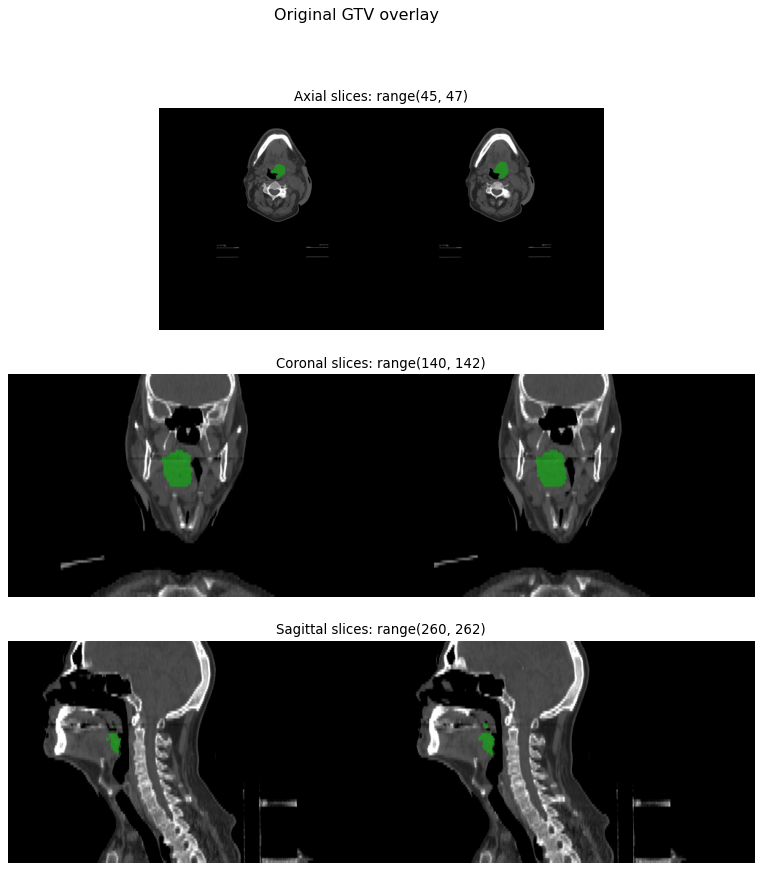

In [8]:
display_overlay_slices(sitk_image1, sitk_image1_seg, 
                       sagittal_slice_idxs=range(260,262),
                       coronal_slice_idxs=range(140,142),
                       axial_slice_idxs=range(45,47),
                       window_level = 200, window_width=800,
                       opacity=0.5,
                       title="Overlay image")